In [ ]:
!pip install datasets
!pip install evaluate
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=r

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset
import evaluate
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt

### Data

In [ ]:
ds = load_dataset("gfissore/arxiv-abstracts-2021")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.75k [00:00<?, ?B/s]

arxiv-abstracts.jsonl.gz:   0%|          | 0.00/940M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1999486 [00:00<?, ? examples/s]

In [ ]:
ds['train'].column_names

['id',
 'submitter',
 'authors',
 'title',
 'comments',
 'journal-ref',
 'doi',
 'abstract',
 'report-no',
 'categories',
 'versions']

In [ ]:
ds['train']['title']

['Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
 'Sparsity-certifying Graph Decompositions',
 'The evolution of the Earth-Moon system based on the dark matter field\n  fluid model',
 'A determinant of Stirling cycle numbers counts unlabeled acyclic\n  single-source automata',
 'From dyadic $\\Lambda_{\\alpha}$ to $\\Lambda_{\\alpha}$',
 'Bosonic characters of atomic Cooper pairs across resonance',
 'Polymer Quantum Mechanics and its Continuum Limit',
 'Numerical solution of shock and ramp compression for general material\n  properties',
 'The Spitzer c2d Survey of Large, Nearby, Insterstellar Clouds. IX. The\n  Serpens YSO Population As Observed With IRAC and MIPS',
 'Partial cubes: structures, characterizations, and constructions',
 'Computing genus 2 Hilbert-Siegel modular forms over $\\Q(\\sqrt{5})$ via\n  the Jacquet-Langlands correspondence',
 'Distribution of integral Fourier Coefficients of a Modular Form of Half\n  Integral Weight Mo

In [ ]:
# Limitar para as primeiras 100 amostras para teste
abstracts = ds['train']['abstract'][:100]
val_titles = ds['train']['title'][:100]

## Test Models

In [ ]:
def rouge_scores(generated_titles, val_titles): #Calcular o Rouge
  rouge = evaluate.load('rouge')
  results = rouge.compute(predictions=generated_titles, references=val_titles)
  return results

def blue_score(generated_titles,val_titles): #Calcular o Blue
  bleu = evaluate.load("bleu")
  results = bleu.compute(predictions=generated_titles, references=[[title] for title in val_titles])
  return results

def meteor_score(generated_titles, val_titles):  # Calcular o METEOR
  meteor = evaluate.load("meteor")
  results = meteor.compute(predictions=generated_titles, references=val_titles)
  return results

def teste_model(abstracts, val_titles, tokenizer, model): #Testar Modelo
  generated_titles = []

  for abstract in abstracts:
    inputs = tokenizer(f"""Generate Title: {abstract}""", return_tensors="pt").to(device)
    outputs = model.generate(**inputs)
    title = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    generated_titles.append(title[0])

  rouge = rouge_scores(generated_titles, val_titles)
  blue = blue_score(generated_titles, val_titles)
  meteor = meteor_score(generated_titles, val_titles)

  return rouge , blue, meteor, generated_titles

### Modelo Base (Flan-T5)

Para o Flan-T5 começamos por testar manualmente as diferentes variações e devido a testar entre as variações Small, Base, Large e XL.
As outras versões maiores tornavam-se computacionalmente impossiveis de se utilizar com os recursos a que temos acesso

#### Flan-T5 - Small


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
r_s, b_s, m_s, gen_titles_flan_s = teste_model(abstracts, val_titles, tokenizer, model)
print(r_s)
print(b_s)
print(m_s)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


{'rouge1': 0.3171834906812326, 'rouge2': 0.1749775766560315, 'rougeL': 0.2984765889406976, 'rougeLsum': 0.30043789188233383}
{'bleu': 0.06123610383284968, 'precisions': [0.24727272727272728, 0.10881542699724518, 0.052547770700636945, 0.027932960893854747], 'brevity_penalty': 0.7724547730159402, 'length_ratio': 0.7947976878612717, 'translation_length': 825, 'reference_length': 1038}
{'meteor': 0.2675192493813021}


#### Flan-T5 - Base


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
r_b, b_b, m_b, gen_titles_flan_b = teste_model(abstracts, val_titles, tokenizer, model)
print(r_b)
print(b_b)
print(m_b)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'rouge1': 0.35096833200344546, 'rouge2': 0.19145113808433228, 'rougeL': 0.3295495163419826, 'rougeLsum': 0.3354090257674698}
{'bleu': 0.04355378317172681, 'precisions': [0.2857142857142857, 0.10839160839160839, 0.048625792811839326, 0.021108179419525065], 'brevity_penalty': 0.5800489066751474, 'length_ratio': 0.6473988439306358, 'translation_length': 672, 'reference_length': 1038}
{'meteor': 0.2820499648044657}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### Flan-T5 - Large


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
r_l, b_l, m_l, gen_titles_flan_l = teste_model(abstracts, val_titles, tokenizer, model)
print(r_l)
print(b_l)
print(m_l)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'rouge1': 0.40562479503567384, 'rouge2': 0.22524765552325496, 'rougeL': 0.3722381031544705, 'rougeLsum': 0.3761210632990466}
{'bleu': 0.07992092050367379, 'precisions': [0.2907268170426065, 0.1318051575931232, 0.07692307692307693, 0.04609218436873747], 'brevity_penalty': 0.7402614238491025, 'length_ratio': 0.7687861271676301, 'translation_length': 798, 'reference_length': 1038}
{'meteor': 0.3433540893770944}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### Flan-T5 - XL

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xl")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-xl")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
r_xl, b_xl, m_xl, gen_titles_flan_xl = teste_model(abstracts, val_titles, tokenizer, model)
print(r_xl)
print(b_xl)
print(m_xl)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'rouge1': 0.40094698556083774, 'rouge2': 0.22756805881061504, 'rougeL': 0.36814152908192305, 'rougeLsum': 0.3741670227698102}
{'bleu': 0.06793218123323175, 'precisions': [0.3163538873994638, 0.12848297213622292, 0.06593406593406594, 0.03803131991051454], 'brevity_penalty': 0.6760955197417521, 'length_ratio': 0.7186897880539499, 'translation_length': 746, 'reference_length': 1038}
{'meteor': 0.33173442014263443}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Callidior/Bert2bert-base-arxiv-titlegen

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Callidior/bert2bert-base-arxiv-titlegen")
model = AutoModelForSeq2SeqLM.from_pretrained("Callidior/bert2bert-base-arxiv-titlegen")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/300 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.17k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/262k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
r_callidior, b_callidior, m_callidior, gen_titles_flan_callidior = teste_model(abstracts, val_titles, tokenizer, model)
print(r_callidior)
print(b_callidior)
print(m_callidior)

{'rouge1': 0.431179224487122, 'rouge2': 0.2534149018168552, 'rougeL': 0.3936644193106781, 'rougeLsum': 0.403586265898085}
{'bleu': 0.09802344146100571, 'precisions': [0.2518315018315018, 0.11290322580645161, 0.06950672645739911, 0.04671717171717172], 'brevity_penalty': 1.0, 'length_ratio': 1.0520231213872833, 'translation_length': 1092, 'reference_length': 1038}
{'meteor': 0.35236925895433047}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Resultados

#### Métricas ROUGE, BLEU e METEOR

- **Rouge** :
  - Rouge-1: Mede a sobreposição de palavras individuais, garantindo que o título contenha os principais termos científicos.
  - Rouge-2: Avalia pares de palavras, importante para criar sequências fluentes e relevantes no título.
  - Rouge-L: Mede a maior sequência de palavras em comum, essencial para garantir que o título siga uma estrutura lógica e coesa.
- **Bleu** :
  - Bleu Score: Avalia a sequência exata de palavras, assegurando precisão e clareza, características importantes para títulos científicos.
  - Precision 1-Gram: Mede a presença de palavras-chave isoladas, garantindo a escolha correta dos termos técnicos mais relevantes.
- **METEOR**: Foca na semântica, capturando a ideia principal do resumo, essencial para que o título reflita com precisão o conteúdo do artigo.


Essas medidas são fundamentais para avaliar a precisão, a estrutura e a semântica dos títulos produzidos. Juntas, estas métricas possibilitam uma análise completa, garantindo que o modelo utilize os termos adequados (Rouge-1, Precision 1-Gram) e cria uma sequência de texto fluida (Rouge-2, Bleu Score), ao mesmo tempo que reflita o significado principal do conteúdo científico (Rouge-L, METEOR).

Essas métricas permitem, neste caso de uso avaliar se o modelo está a criar títulos precisos, informativos e relevantes para o respetivo artigo.

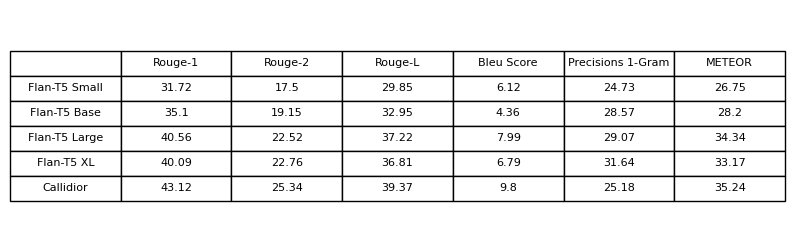

In [4]:
# Dados da tabela
data = [
    ["", "Rouge-1", "Rouge-2", "Rouge-L", "Bleu Score", "Precisions 1-Gram", "METEOR"],  # Cabeçalhos das colunas
    ["Flan-T5 Small", 31.72, 17.50, 29.85, 6.12, 24.73, 26.75],
    ["Flan-T5 Base", 35.10, 19.15, 32.95, 4.36, 28.57, 28.20],
    ["Flan-T5 Large", 40.56, 22.52, 37.22, 7.99, 29.07, 34.34],
    ["Flan-T5 XL", 40.09, 22.76, 36.81, 6.79, 31.64, 33.17],
    ["Callidior", 43.12, 25.34, 39.37, 9.80, 25.18, 35.24],
]

# Criar a figura
fig, ax = plt.subplots(figsize=(5, 3))
ax.axis("off")  # Esconder os eixos

# Adicionar a tabela
table = ax.table(cellText=data, loc="center", cellLoc="center", colLoc="center")

# Estilizar a tabela
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(2, 1.5)

# Exibir a tabela
plt.show()

Analisando primeira as variaçoes do Flan T5 conseguimos verificar que o modulo que obteve melhores resultados foi o modelo XL, como já era esperado. Apesar de ser um modelo maior que os restantes, a usa utilização é rápida.


Como era esperado o modelo que usamos já treinado especificamente para a criação de títulos apartir de asbtractos é o que melhores resultados apresenta. É o mais capaz de capturar vocabulário, coesão, estrutura e significado dos títulos de referência e por isso será o modelos utilizado na versão final do projeto

Apesar destes resultados, estes podem ser subjetivos, já que a comparação foi feita ao título já existente. Como um título é algo subjetivo e requer a opinião humana para o avalair, foram avaliados alguns títulos e usamos também essa avaliação para escolher o modelo Callidior/bert2bert-base-arxiv-titlegen